<a href="https://colab.research.google.com/github/lc0/deeplearning-playground/blob/master/TF2/tf2_tiff_images_dataset_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf-nightly-gpu-2.0-preview

    100% |████████████████████████████████| 322.1MB 84kB/s 
    100% |████████████████████████████████| 3.2MB 7.8MB/s 
    100% |████████████████████████████████| 61kB 27.3MB/s 
    100% |████████████████████████████████| 348kB 13.5MB/s 


In [0]:
import tensorflow as tfgith

# Data

## initial training dataset

In [0]:
from google.colab import files

uploaded = files.upload()

Saving photomask_trainingdata.zip to photomask_trainingdata.zip


In [5]:
!ls -la

total 5572
drwxr-xr-x 1 root root    4096 Feb 10 14:57 .
drwxr-xr-x 1 root root    4096 Feb 10 14:50 ..
drwxr-xr-x 1 root root    4096 Feb  6 17:30 .config
drwxr-xr-x 3 root root    4096 Feb 10 14:57 dataset
-rw-r--r-- 1 root root 2430745 Feb 10 14:54 photomask_testdata.zip
-rw-r--r-- 1 root root 3249054 Feb 10 14:56 photomask_trainingdata.zip
drwxr-xr-x 1 root root    4096 Feb  6 17:31 sample_data


In [6]:
!unzip photomask_trainingdata.zip -d dataset

Archive:  photomask_trainingdata.zip
replace dataset/photomask_trainingdata/COMPLETE FEATURE/026_2.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
rm -r dataset/__MACOSX/

rm: cannot remove 'dataset/__MACOSX/': No such file or directory


In [0]:
dataset_path = 'dataset/photomask_trainingdata/'

In [9]:
!ls -la {dataset_path}

total 20
drwxrwxrwx 5 root root 4096 Feb  5 17:17  .
drwxr-xr-x 3 root root 4096 Feb 10 14:57  ..
drwxrwxrwx 2 root root 4096 Feb  5 17:04  BORDERTOUCHER
drwxrwxrwx 2 root root 4096 Feb  5 17:05 'COMPLETE FEATURE'
drwxrwxrwx 2 root root 4096 Feb  5 17:04 'NO FEATURE'


## TF Dataset based on the files

In [11]:
import tensorflow as tf

tf.version.VERSION

'2.0.0-dev20190208'

In [0]:
work_image_size = [28, 28]

batch_size = 16

In [23]:
from os import listdir, path

class_names = listdir(dataset_path)
# print(class_names)

class_folders = [(idx, path.join(dataset_path, class_name)) for idx, class_name in enumerate(class_names)]
# print(class_folders)

['NO FEATURE', 'COMPLETE FEATURE', 'BORDERTOUCHER']
[(0, 'dataset/photomask_trainingdata/NO FEATURE'), (1, 'dataset/photomask_trainingdata/COMPLETE FEATURE'), (2, 'dataset/photomask_trainingdata/BORDERTOUCHER')]


In [0]:
filenames = []
class_ids = []
for class_id, folder in class_folders:
  files = listdir(folder)
  
  filenames.extend([path.join(folder, filename) for filename in listdir(folder)])
  class_ids.extend([class_id for filename in listdir(folder)])


len(filenames)
assert len(class_ids) == len(class_ids)

Unfortunately `tf.py_function` can only return a tuple. With generic `map` we can work with `dict` interface

In [0]:
from PIL import Image
import numpy as np

def parse_tiff_py(filename, class_id):
    print(filename.numpy())
    
    im = Image.open(filename.numpy())
    im = im.resize(work_image_size)
    
    return np.array(im), class_id

Now we just need to add our python function to `dataset` pipeline. We can do with follow `lambda` trick

In [108]:
dataset = tf.data.Dataset.from_tensor_slices((filenames, class_ids))
dataset = dataset.shuffle(len(filenames))

dataset = dataset.map(lambda filename, label: tf.py_function(
              parse_tiff_py, 
              (filename, label),  
              [tf.uint8, label.dtype]))

dataset

<MapDataset shapes: (<unknown>, <unknown>), types: (tf.uint8, tf.int32)>

In [109]:
features = dataset.take(1)
features

<TakeDataset shapes: (<unknown>, <unknown>), types: (tf.uint8, tf.int32)>

In [110]:
for row in features:
  print(row)
  image = row[0]
  label = row[1]

b'dataset/photomask_trainingdata/COMPLETE FEATURE/006_2.tif'
(<tf.Tensor: id=503, shape=(28, 28), dtype=uint8, numpy=
array([[127, 191, 130, 240, 146, 147, 105, 174, 122, 150, 221, 155,  84,
        186, 128,  99,  90, 146, 138, 192, 196, 106, 157, 153,  56, 151,
        148, 170],
       [229, 208, 135, 158, 125, 110, 172, 137, 102, 168,  84, 145, 130,
        122, 139, 129, 175, 154, 111, 227, 155, 131, 153, 132, 147, 171,
        141, 150],
       [122, 162, 216, 235, 181, 104, 109, 160, 154, 161, 122, 129, 193,
        109, 169, 100, 175,  91, 136, 131, 174, 145, 153, 127, 140, 175,
        134,  92],
       [120, 197, 117, 160, 117,  97, 216, 124, 172, 165, 165, 179, 101,
        100, 216, 158, 138, 180, 152, 170, 151, 174, 132, 179, 163, 186,
         64, 126],
       [119, 156, 150, 151, 245, 111, 162, 125, 184, 167, 165, 173, 198,
        162, 163, 170, 180, 250, 159, 139, 166, 170, 160,  72, 158, 123,
        108, 154],
       [248, 138, 106, 111, 122, 123, 171, 136, 157, 244,

(28, 28)
Label - COMPLETE FEATURE


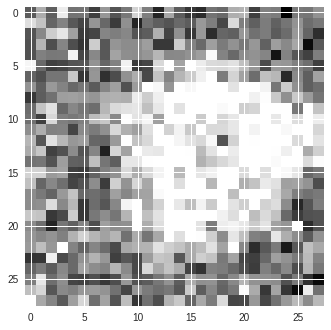

In [111]:
import matplotlib.pyplot as plt

print(image.shape)
plt.imshow(image, cmap=plt.get_cmap("gray"))

print(f"Label - {class_names[label]}")